In [1]:
%load_ext autoreload
%autoreload 2

# Import

In [2]:
from IPython.display import clear_output

#import plotly 
#import plotly.graph_objects as go

import matplotlib
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
import datetime as dt
#import seaborn as sns
import pandas as pd
import numpy as np
import talos as ta
import math
import time
import sys
import os

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from talos.utils.gpu_utils import parallel_gpu_jobs
from talos.model.normalizers import lr_normalizer
#from matplotlib.dates import bytespdate2num
from matplotlib import style
from time import time

from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import Embedding, Input, SpatialDropout1D
#from keras.layers.convolutional import AtrousConvolution1D
from keras.layers import GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.optimizers import RMSprop, Adam, SGD, Nadam, Adamax
from keras.utils import plot_model, np_utils, to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.advanced_activations import *
from keras.initializers import *
from keras.constraints import *
from keras import backend as K
from keras import regularizers
from keras import losses

In [3]:
from nsp.serie_process import Serie, create_Xt_Yt
from nsp.nsp_utils import simple_func, find_result, find_gap, find_hldif, find_emad, find_stoch, find_volat, segnale_base

# Carica dati

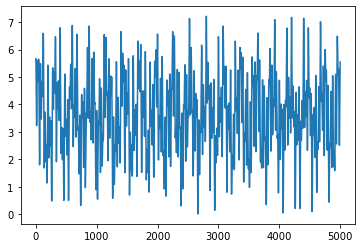

In [4]:
T = 5000
x = np.arange(0,T)
y=  np.sin(4.3*np.pi*x/200)+np.cos(8*np.pi*x/100)+np.cos(2.5*np.pi*x/50)+np.sin(0.9*np.pi*x/123)
y = y + abs(min(y)) + 0.01
plt.plot(x, y)

In [5]:
sinusoide = Serie(x,y)

In [4]:
%store -r norm 
%store -r norm_index

In [323]:
norm = norm + abs(min(norm)) + 0.1

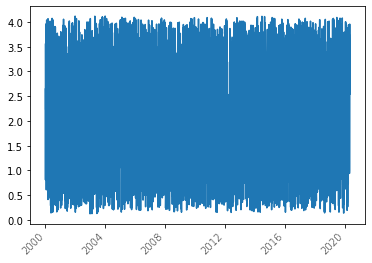

In [324]:
plt.plot(norm_index, norm)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
);

In [6]:
data_original=sinusoide.df

In [7]:
WINDOW = 32   #@param {type:"slider", min:10, max:90, step:10}
EMB_SIZE = 4  # колич. входных перем.
#@markdown The size of the test data.
PERCENT = 0.2   #@param {type:"slider", min:0, max:1, step:0.05}
STEP = 1      # шаг
#@markdown Prediction Range (in days).
FORECAST = 1

# Period of Fast EMA
fast_emad = 8 #@param {type:"slider", min:1, max:16, step:1}
# Period of Slow EMA
slow_emad = 18 #@param {type:"slider", min:1, max:32, step:1}
# K period for the stochastic oscillator
k_stoch = 5 #@param {type:"slider", min:1, max:16, step:1}
# Smoothing Period for Stochastic Oscillator
smooth_stoch = 3 #@param {type:"slider", min:1, max:8, step:1}
# Volatility Calculation Period
period_volat = 6 #@param {type:"slider", min:1, max:16, step:1}
# Autocorrelation period
window_autocorr = 30 #@param {type:"slider", min:10, max:90, step:5}
# Autocorrelation lag
lag_autocorr = 4 #@param {type:"slider", min:1, max:10, step:1}

sinusoide.aggiungi_indicatori(window_autocorr, lag_autocorr, fast_emad, slow_emad, period_volat, k_stoch, smooth_stoch)

In [11]:
sinusoide.new_data#[['Date','AUTCOR','CLOSE','EMAD','VOLAT']]

,Date,AUTCOR,CLOSE,EMAD,VOLAT
0,30,0.722785,0.756615,0.641224,0.059116
1,31,0.732569,0.742188,0.628496,0.091687
2,32,0.739237,0.726083,0.610368,0.149526
3,33,0.741312,0.709980,0.588908,0.194116
4,34,0.736945,0.695488,0.566257,0.217756
...,...,...,...,...,...
4965,4995,0.744522,0.648045,0.542562,0.705537
4966,4996,0.758917,0.690333,0.601552,0.713345
4967,4997,0.765124,0.725722,0.653971,0.683622
4968,4998,0.765914,0.752258,0.697150,0.617738


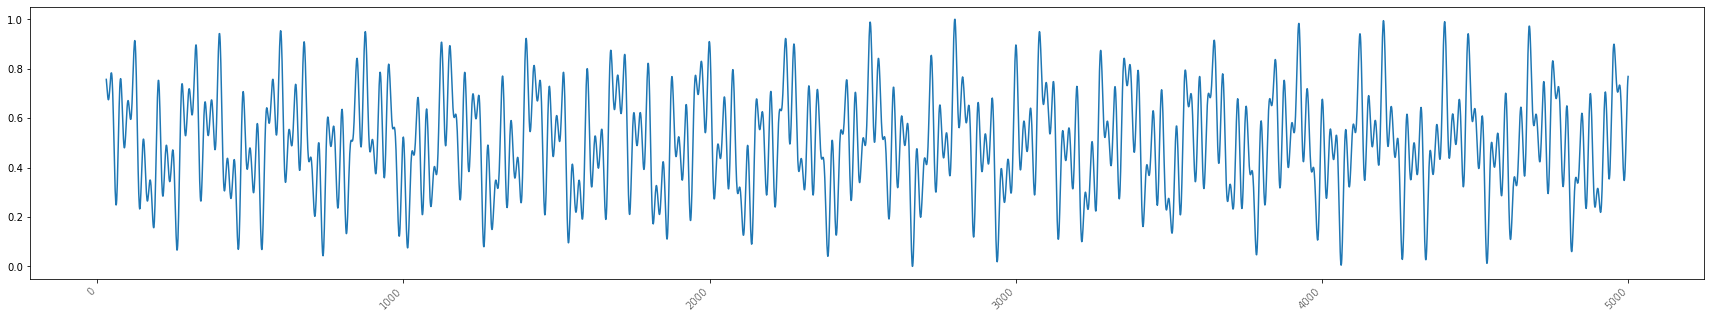

In [14]:
plt.figure(figsize=(30,5))
plt.plot(new_data['Date'], new_data['CLOSE'])
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
);


In [329]:
### i primi livelli convnet dovrebbero leggere i dati scalati tra max e min dell'intervallo breve che hanno in input

# Pre-preparation of data for training a neural network

In [24]:
data, label = sinusoide.crea_pezzetti_window(WINDOW, STEP, FORECAST)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(data, label, PERCENT)

# Train

In [297]:
from model import create_model, only_recurrent_model

In [1]:
model = create_model(WINDOW, EMB_SIZE, learning_rate=0.0005)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=500, min_lr=0.0000001, verbose=0)
checkpointer = ModelCheckpoint(filepath="test_normalizzato.hdf5", verbose=2, save_best_only=True)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./log')#, histogram_freq=0, write_graph=True, write_images=True)
history = model.fit(X_train, Y_train, 
              epochs = 6000, 
              batch_size = 512, 
              verbose=2, 
              validation_data=(X_test, Y_test),
              callbacks=[reduce_lr], #checkpointer
              shuffle=True)

NameError: name 'create_model' is not defined

In [45]:
# Carica un modello già addestrato
#model.load_weights("weights.h5")

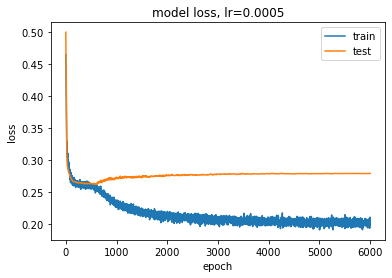

In [409]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss, lr=0.0005')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
#plt.savefig('lr_0.0005_reduce-lr_model_big1.jpg')
plt.show()

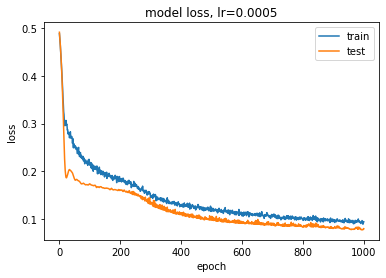

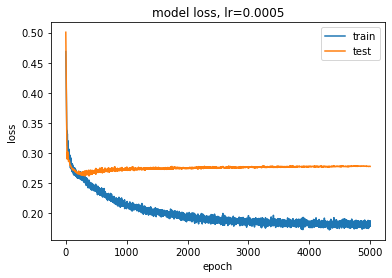

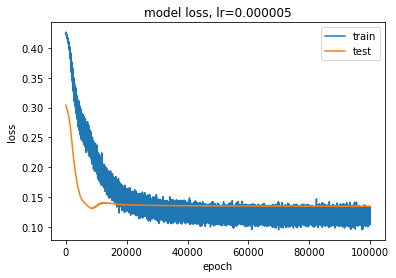

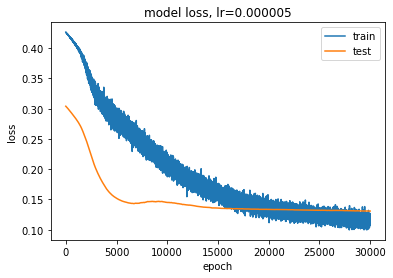

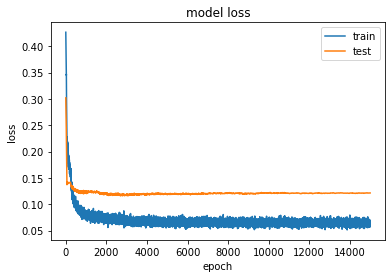

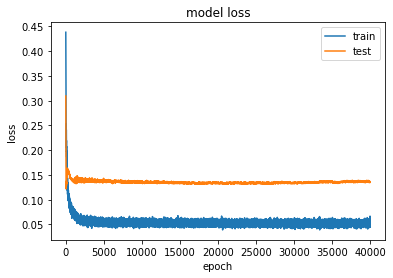

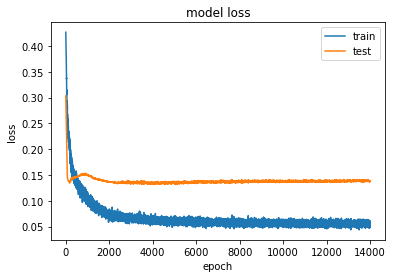

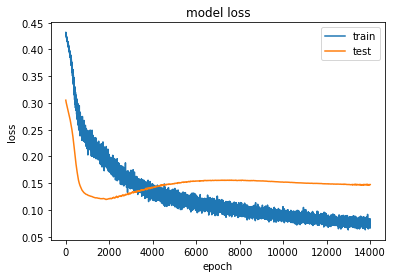

<Figure size 432x288 with 0 Axes>

# Quick analysis (prediction and backtesting)

In [394]:
pred = model.predict(X_test)
predicted = pred
original = Y_test

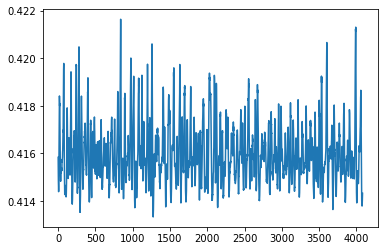

In [400]:
plt.plot(pred)

In [395]:
predic = pd.DataFrame(predicted)
fact = pd.DataFrame(original)
itog = pd.concat([predic, fact], axis=1)
itog.columns = (['pred', 'fact'])
itog["predUD"] = find_result(predic)
itog["factUD"] = find_result(fact)

true_long = 0
true_short = 0
vern = 0

for i in range(0,len(itog)):
    if itog["predUD"][i] > 0.5 and itog["factUD"][i] > 0.5:
        true_long = true_long + 1
    elif itog["predUD"][i] < 0.5 and itog["factUD"][i] < 0.5:
        true_short = true_short + 1
  
    if itog["predUD"][i] == itog["factUD"][i]:
        vern = vern + 1
    
per_long = round((true_long/len(itog[itog["factUD"]>0.5]))*100,2)
per_short = round((true_short/len(itog[itog["factUD"]<0.5]))*100,2)
per_vern = round((vern/len(itog))*100,2)

print("Percentage of open orders for increase:", per_long)
print("Percentage of open orders for decrease:", per_short)
print("")
print("The percentage of correct forecasts:", per_vern)
print("--------------------------------------")
itog.head()

print ("MSE =", np.mean(np.square(predicted - original)))
print ("MAE =", np.mean(np.abs(predicted - original)))
print ("MAPE =", np.mean(np.abs((original - predicted) / original)))

Percentage of open orders for increase: 53.04
Percentage of open orders for decrease: 49.59

The percentage of correct forecasts: 51.3
--------------------------------------
MSE = 0.09177578660872433
MAE = 0.26438660306993556
MAPE = 1.3658517151468543


# Backtest

In [396]:
from nsp_utils import segnale_base
from Backtest_mio import Backtest_mio

#@markdown The amount of initial capital.
CAPITAL = 1000
#@markdown The share of capital to which we open the order.
CHAST = 0.1
#@markdown The size of the commission for opening/closing an order (%).
commissioni = 0.001


In [397]:
data_original.reset_index(inplace=True) # Вытаскиваем Дату из индекса
test_dates = pd.DataFrame(np.array(data_original["Date"][-len(Y_test):]))
test_price = pd.DataFrame(np.array(data_original["Close"][-len(Y_test):]))
data_original = data_original.set_index('Date') # устанавливаем Дату как индекс обратно
#test_signal = pd.DataFrame(np.array(find_result(pd.DataFrame(pred))))

backtest = Backtest_mio(test_price.values, 1000, commissioni, commissioni_fisse=0)

In [398]:
# definisco il segnale e parto con il test
test_signal = segnale_base(pred, commissioni)
backtest.calcola(test_signal)

Portfolio Change: 0.0 % in 4082 days


<Figure size 2160x360 with 0 Axes>

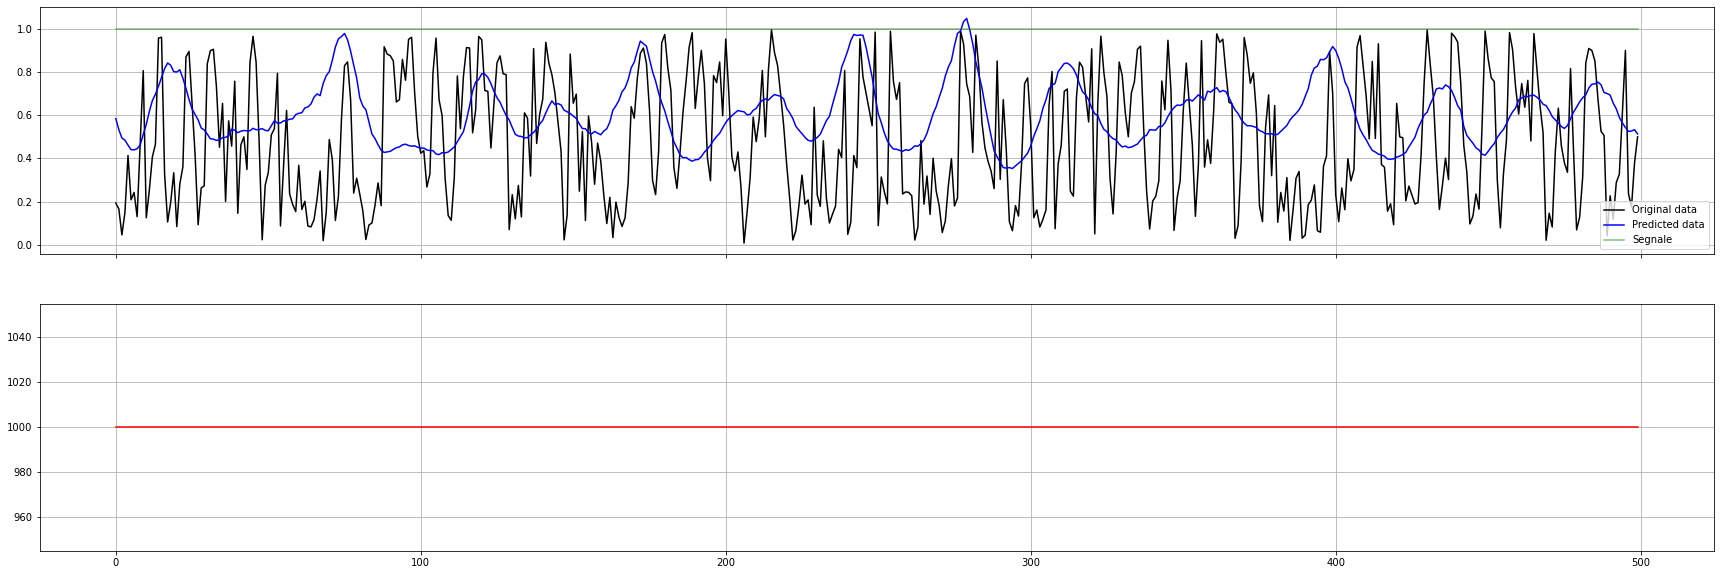

In [407]:
orig = pd.DataFrame(original)
perd = pd.DataFrame(predicted)
capi = pd.DataFrame(backtest.capitale_tempo)
df_signale = pd.DataFrame(test_signal)
stocks = pd.DataFrame(backtest.stock)
itog = pd.concat([orig, perd, capi, df_signale, stocks], axis=1)
itog.columns = (['orig', 'perd', 'capi', 'sig', 'stocks'])


print("Portfolio Change:", round((itog['capi'][len(itog['capi'])-1] - itog['capi'][0])*100, 1),"% in", len(itog['capi']), "days")

plt.figure(figsize=(30,5))
f, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(30,10))
#f, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(30,15))

start, stop = (0, 500)
ax1.plot(itog['orig'][start:stop], color = 'black', label = 'Original data')
ax1.plot(itog['perd'][start:stop]*100-41, color = 'blue', label = 'Predicted data')
ax1.plot(itog['sig'][start:stop], color = 'green', label = 'Segnale', alpha=0.5)
ax1.legend()
ax1.grid(True, which='major')

ax2.plot(itog['capi'][start:stop], color = 'red', label = 'Capital')
ax2.grid(True, which='major')
#ax3.plot(itog['stocks'][start:stop], color = 'brown', label = 'Stocks')
#plt.yscale('log')

plt.show()

In [19]:
# Save the weight and architecture of the neural network
model.save_weights('weights.h5', overwrite=True)
model.save('model.h5', overwrite=True)

# Save the network architecture in JSON format
model_json = model.to_json()
json_file = open("test.json", "w")
json_file.write(model_json)
json_file.close()